# Project 2: 全景图像拼接

启动Jupyter并打开`Project2.ipynb`。

在本项目中，你将实现一个全景图像拼接器。这将建立在项目 1 中开发的兴趣点和描述符的基础上。您将首先通过 RANSAC 进行几何过滤，然后估计成对旋转并将其链接在一起以对齐全景图。当您有一个基本的缝合器工作时，使用更好的对齐、混合或其他新功能来改进它，并记录您的发现。

In [19]:
import numpy as np
import scipy.linalg
import os.path
from time import time
import types
import matplotlib.pyplot as plt

import im_util
import interest_point
import ransac
import geometry
import render
import panorama

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# force auto-reload of import modules before running code 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 图像变形测试

下面的代码使用一个3x3变换矩阵对图像进行变形。使用矩阵P进行实验，测试课堂上描述的一些不同的二维变换，例如，相似性变换、仿射变换和投影变换。

(-0.5, 567.5, 757.5, -0.5)

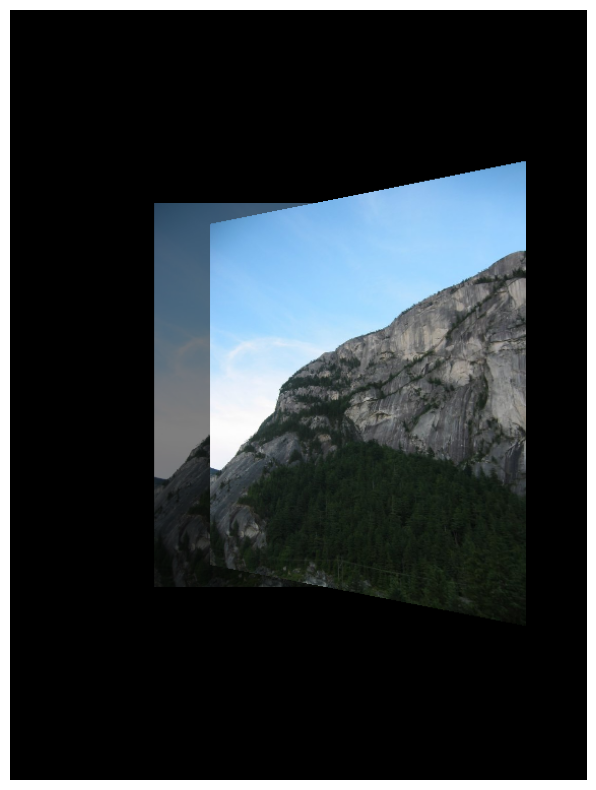

In [20]:
# read image
image_dir='data/test'
im_filename1=image_dir+'/100-0038_img.jpg'
im=im_util.image_open(im_filename1)
im_rows,im_cols,_=im.shape

# set transformation matrix
P=[[1, 0.2, -64],
  [ 0, 1.1, -120],
  [ 0, 5.2e-4, 0.83]]

# warp coordinates
r0,r1=-im_rows/2, im_rows*3/2
c0,c1=-im_cols/2, im_cols*3/2
warp_rows, warp_cols=im_rows, im_cols

coords=im_util.coordinate_image(warp_rows,warp_cols,r0,r1,c0,c1)
coords_t=im_util.transform_coordinates(coords, P)

# visualise result
warp_im1=im_util.warp_image(im,coords)
warp_im2=im_util.warp_image(im,coords_t)
alpha=im_util.warp_image(np.ones((im_rows,im_cols,1)),coords_t)
result_im=warp_im2*alpha + 0.5*warp_im1*(1-alpha)

ax1=plt.subplot(1,1,1)
plt.imshow(result_im)
plt.axis('off')

### 兴趣点测试

我们将使用在项目1("Project 1")中实现的兴趣点和描述符。如果你在让这些工作起来时遇到了困难，或者想要测试另一种匹配算法，你可以尝试使用 vlfeat/sift，见下文。注意你需要安装 cyvlfeat，例如，使用 conda 安装：`conda install -c menpo cyvlfeat`。

```python
from cyvlfeat import sift 
frames, desc = sift.sift(img, compute_descriptor=True, n_levels=1)
ip = (frames.T)[0:2, :]
desc = desc.astype(np.float)
```

运行下面的两个代码块来检查你的兴趣点和描述符是否工作正常。为了让后续步骤顺利进行，你应该争取获得大约100-1000个兴趣点。

In [21]:
"""
Read a pair of input images and convert to grey
"""
image_dir='data/test'
#im_filename1=image_dir+'/100-0023_img.jpg'
#im_filename2=image_dir+'/100-0024_img.jpg'
im_filename1=image_dir+'/100-0038_img.jpg'
im_filename2=image_dir+'/100-0039_img.jpg'

im1 = im_util.image_open(im_filename1)
im2 = im_util.image_open(im_filename2)

img1 = np.mean(im1, 2, keepdims=True)
img2 = np.mean(im2, 2, keepdims=True)

#optionally plot images
#ax1,ax2=im_util.plot_two_images(im1, im2)

"""
Find interest points in the image pair
"""
print('[ find interest points ]')
t0=time()
ip_ex = interest_point.InterestPointExtractor()
ip1 = ip_ex.find_interest_points(img1)
print(' found '+str(ip1.shape[1])+' in image 1')
ip2 = ip_ex.find_interest_points(img2)
print(' found '+str(ip2.shape[1])+' in image 2')
t1=time()
print(' % .2f secs ' % (t1-t0))

# optionally draw interest points
#print('[ drawing interest points ]')
#ax1,ax2=im_util.plot_two_images(im1,im2)
#interest_point.draw_interest_points_ax(ip1, ax1)
#interest_point.draw_interest_points_ax(ip2, ax2)

[ find interest points ]
 found 328 in image 1
 found 415 in image 2
  0.23 secs 


[ extract descriptors ]
  0.10 secs
[ match descriptors ]
  0.00 secs
[ drawing matches ]
  0.37 secs


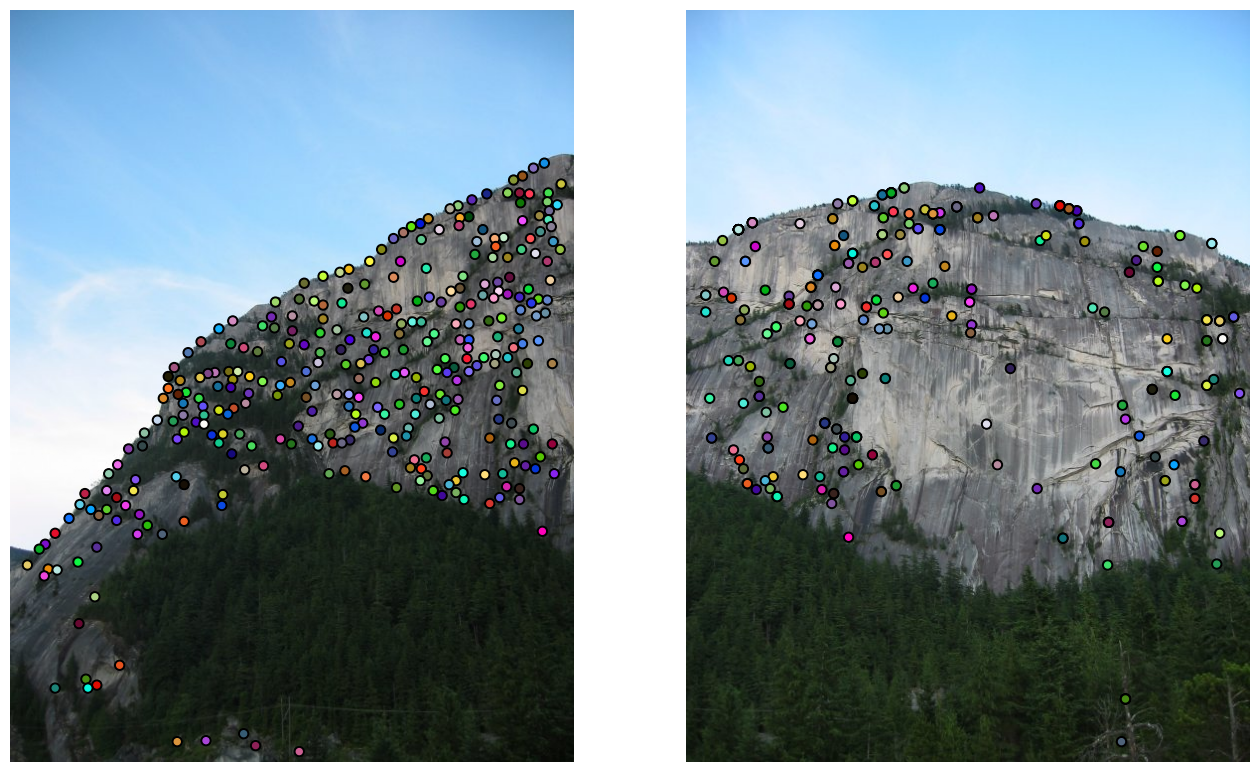

In [22]:
"""
Extract and match descriptors
"""
print('[ extract descriptors ]')
t0=time()
desc_ex = interest_point.DescriptorExtractor()
desc1 = desc_ex.get_descriptors(img1, ip1)
desc2 = desc_ex.get_descriptors(img2, ip2)
t1=time()
print(' % .2f secs' % (t1-t0))

print('[ match descriptors ]')
t0=time()
match_idx = desc_ex.match_descriptors(desc1, desc2)
t1=time()
print(' % .2f secs' % (t1-t0))

ipm=ip2[:,match_idx]

print('[ drawing matches ]')
t0=time()
ax1,ax2=im_util.plot_two_images(im1,im2)
interest_point.draw_matches_ax(ip1, ipm, ax1, ax2)
t1=time()
print(' % .2f secs' % (t1-t0))

## RANSAC 实现

我们现在将使用 RANSAC 来找到一致的匹配。

### 一致性测试 [3分]

首先，我们将实现一个测试，以计算与相似性变换一致的匹配数量。下面的代码生成一个随机的相似性变换 S 和一组随机点 x。然后它变换这些点并添加噪声，并检查有多少点与真实的相似性变换 S 一致。

打开 `ransac.py` 并实现函数 `consistent`。当运行下面的代码时，你应该发现有高比例（约80%或更多）的点与真实的相似性变换 S 一致。

In [23]:
"""
Test RANSAC functions using synthetic data
"""
# make a random S matrix
sd_pos=100
sd_angle=np.pi
theta=np.random.randn()*sd_angle
tx=np.random.randn()*sd_pos
ty=np.random.randn()*sd_pos
ct=np.cos(theta)
st=np.sin(theta)
S=[[ct,st,tx],[-st,ct,ty],[0,0,1]]

# generate random points
num_points=100
sd_points=20
x = np.random.randn(2,num_points)*sd_points
xh = geometry.hom(x)

# transform points and add noise
sd_noise=5
yh = np.dot(S, xh)
y = geometry.unhom(yh)
yn = y + np.random.randn(2,num_points)*sd_noise

print('[ Test of consistent ]')
rn = ransac.RANSAC()
inliers0=rn.consistent(S,x,yn)
num_consistent=np.sum(inliers0)
print(' number of points consistent with true S = '+str(num_consistent))
if (num_consistent > 0.75*num_points):
    print(' consistency check is working!')

[ Test of consistent ]
 number of points consistent with true S = 92.0
 consistency check is working!


### 相似性求解器 [4分]

现在选择2个点对应的样本，并计算与该对应的相似性变换。在 `ransac.py` 中实现 `compute_similarity` 函数，并运行下面的代码来计算内点的数量。尝试改变样本的索引，观察内点数量的变化。是否存在退化情况？如何检测这些情况？

In [24]:
print('[ Test of compute_similarity ]')
sample=[i for i in range(num_points)]
S1=rn.compute_similarity(x[:,sample],yn[:,sample])
inliers1=rn.consistent(S1,x,yn)
num_consistent=np.sum(inliers1)
print(' number of points consistent with sample S = '+str(num_consistent))

[ Test of compute_similarity ]
 number of points consistent with sample S = 93.0


### RANSAC 循环 [3分]

最后，通过完成 `ransac.py` 中的 `ransac_similarity` 函数来完成 RANSAC 的实现。完成后，您应该会发现大多数点都被标记为一致。

In [25]:
print('[ Test of ransac_similarity ]')
S2, inliers2=rn.ransac_similarity(x, yn)
num_consistent=np.sum(inliers2)
print(' number of points consistent with ransac S = '+str(num_consistent))
if (num_consistent > 0.75*num_points):
    print(' ransac succeeded!')

[ Test of ransac_similarity ]
 number of points consistent with ransac S = 90
 ransac succeeded!


现在我们将离开合成测试数据，使用上面输入图像对获取的兴趣点匹配运行相同的代码。请查看下面的代码，并检查输出是否合理。您应该会看到一组良好的几何一致的匹配点。

[ do ransac ]
 found 94 matches
  0.60 secs
[ drawing matches ]
  0.23 secs


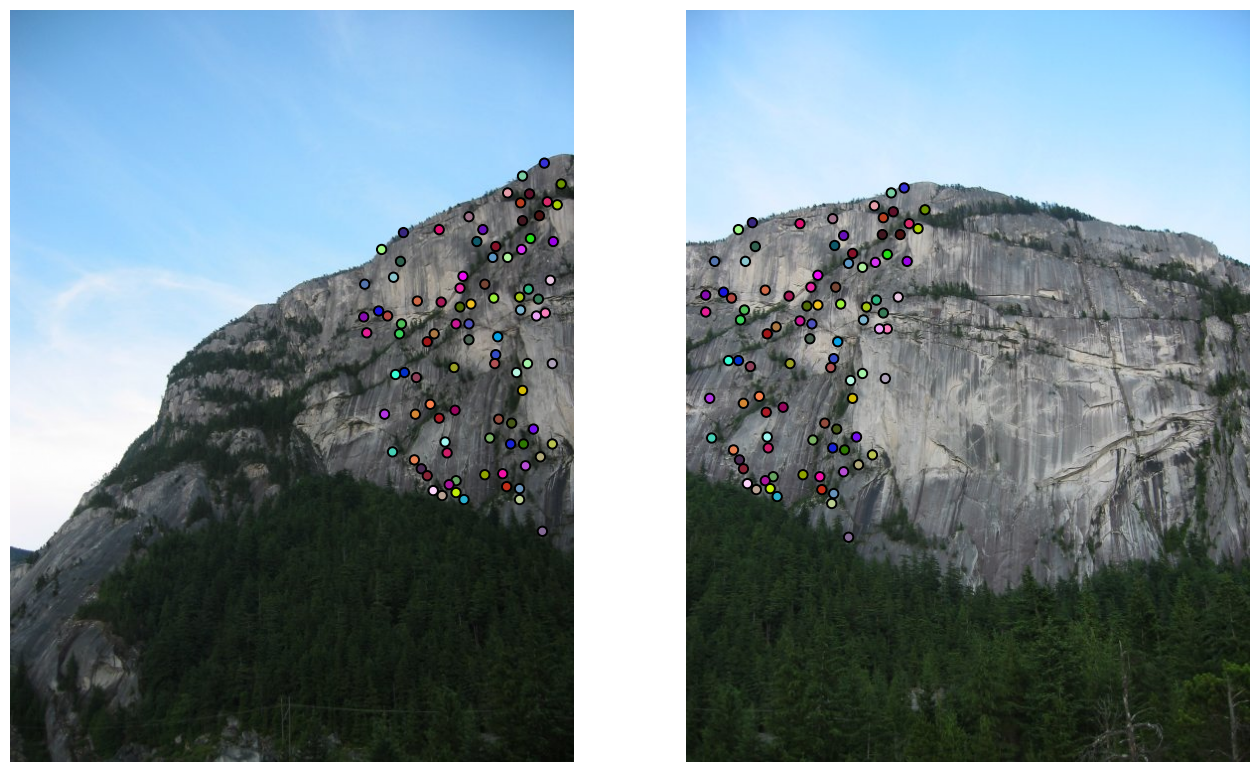

In [26]:
"""
Perform RANSAC on interest point matches
"""
print('[ do ransac ]')
t0=time()
rn = ransac.RANSAC()
S, inliers = rn.ransac_similarity(ip1,ipm)
t1=time()
num_inliers_s = np.sum(inliers)
print(' found '+str(num_inliers_s)+' matches')
print(' % .2f secs' % (t1-t0))

ip1c = ip1[:, inliers]
ipmc = ipm[:, inliers]

print('[ drawing matches ]')
t0=time()
ax1,ax2=im_util.plot_two_images(im1,im2)
interest_point.draw_matches_ax(ip1c, ipmc, ax1, ax2)
t1=time()
print(' % .2f secs' % (t1-t0))

# optionally plot descriptors for matched points
#inlier_id=np.flatnonzero(inliers)
#match_id=match_idx[inlier_id]
#interest_point.plot_matching_descriptors(desc1,desc2,inlier_id,match_id,plt)

### 旋转估计 [3分]

下一个任务是估计图像之间的真实旋转。为了做到这一点，我们将猜测输入图像的视场角，并使用一个闭合形式的算法来估计旋转。打开 `geometry.py` 并完成 `compute_rotation` 函数的实现。您应该会发现大量的匹配点与您的旋转一致，并且成对的变形图像应该看起来合理。尝试调整视场角参数。对于这些图像来说，最佳的视场角是多少？

[ estimate rotation ]
 assuming fov=45
 num consistent with rotation = 72.0
  0.00 secs
[ test pairwise warp ]
  0.07 secs


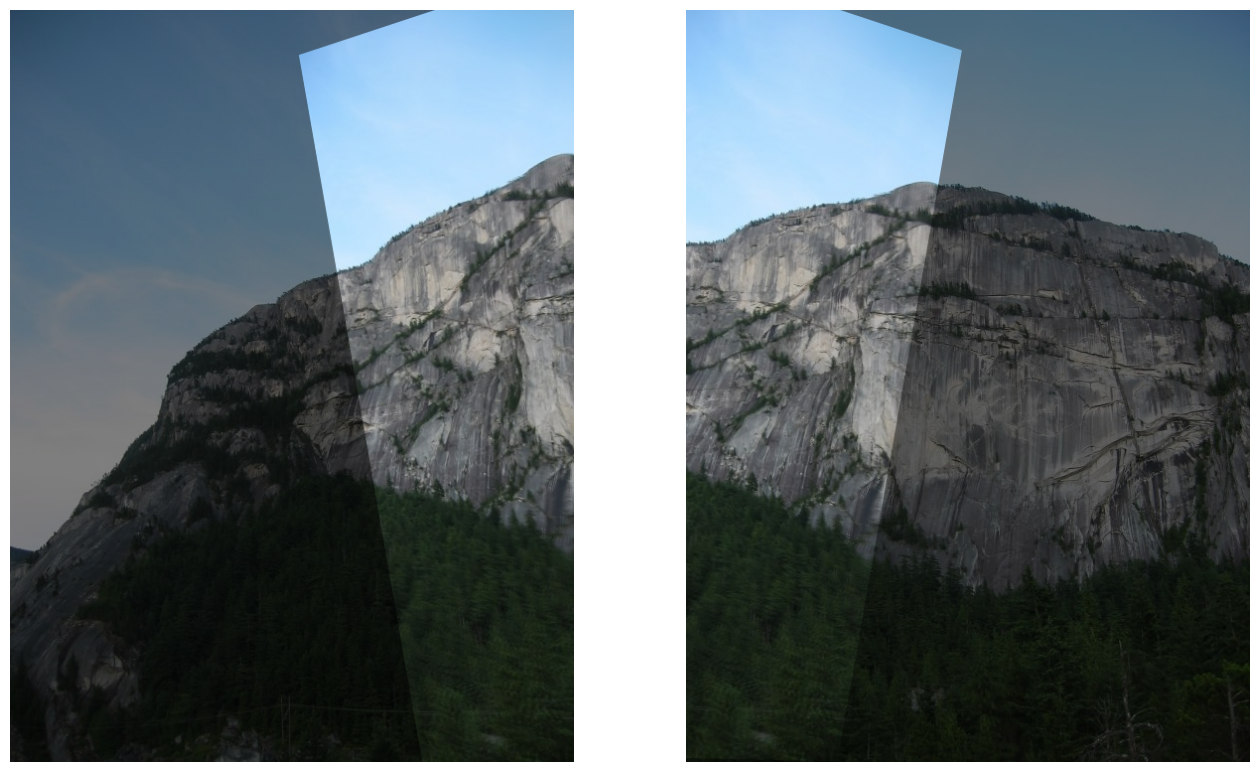

In [27]:
"""
Estimate rotation matrix by least squares
"""
print('[ estimate rotation ]')
t0=time()
# Note: assume field of view of 45 degrees
fov_degrees=45
print(' assuming fov='+str(fov_degrees))
K1 = geometry.get_calibration(im1.shape, fov_degrees)
K2 = geometry.get_calibration(im2.shape, fov_degrees)
R,H = geometry.compute_rotation(ip1c, ipmc, K1, K2)

num_inliers_r = np.sum(rn.consistent(H, ip1, ipm))
print(' num consistent with rotation = '+str(num_inliers_r))
if (num_inliers_r>0.9 * num_inliers_s):
    print(' compute rotation succeeded!')
t1=time()
print(' % .2f secs' % (t1-t0))
    
print('[ test pairwise warp ]')
t0=time()
im1_w, im2_w = render.pairwise_warp(im1, im2, H)
_= im_util.plot_two_images(0.5*(im1+im2_w), 0.5*(im2+im1_w))
t1=time()
print(' % .2f secs' % (t1-t0))

以下代码将在球坐标系中渲染对齐的图像。请检查图像是否对齐良好。

[ render aligned images ]
  0.15 secs


(-0.5, 799.5, 532.5, -0.5)

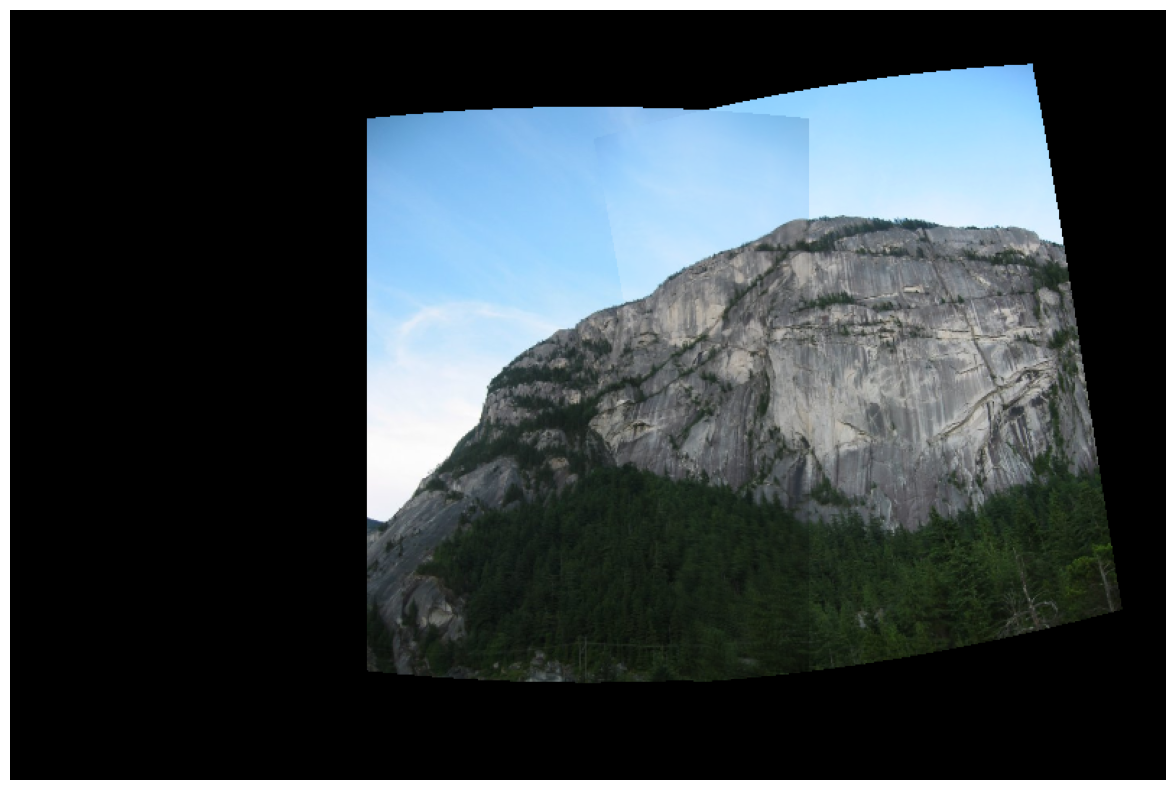

In [28]:
"""
Render 2 images in spherical coordinates
"""
images=[im1,im2]
P1=K1
P2=np.dot(K2,R)
P_matrices=[P1,P2]

render_params={}
render_params['render_width']=800
render_params['theta_min']=-45
render_params['theta_max']=45
render_params['phi_min']=-30
render_params['phi_max']=30

print ('[ render aligned images ]')
t0=time()
pano_im=render.render_spherical(images, P_matrices, render_params)
t1=time()
print(' % .2f secs' % (t1-t0))

plt.plot()
plt.imshow(pano_im)
plt.axis('off')

让我们添加更多的图像！`panorama.py` 中的 `PanoramaStitcher` 类的方法 `match_images` 接受一组图像作为输入，并将兴趣点和匹配代码封装在其中。请查看这个函数，并使用下面的代码在一组图像上进行测试。

In [29]:
"""
Read a set of input images
"""

print('[ read images ]')
image_dir='data/test'
im_filenames=os.listdir(image_dir)
im_filenames=[image_dir+'/'+fname for fname in im_filenames]

#im_filenames=[]
#im_filenames.append(image_dir+'/100-0023_img.jpg')
#im_filenames.append(image_dir+'/100-0024_img.jpg')
#im_filenames.append(image_dir+'/100-0038_img.jpg')
#im_filenames.append(image_dir+'/100-0039_img.jpg')

images=[]
for fname in im_filenames:
  images.append(im_util.image_open(fname))

"""
Stitch images
"""
stitch_params={}
stitch_params['fov_degrees']=45

num_images = len(im_filenames)
print(' stitching '+str(num_images)+' images')

pano=panorama.PanoramaStitcher(images, stitch_params)
pano.match_images()

print(' num_matches=')
print(pano.num_matches)

[ read images ]
 stitching 7 images
[ find interest points ]
 found 490 interest points
 found 586 interest points
 found 620 interest points
 found 385 interest points
 found 505 interest points
 found 415 interest points
 found 328 interest points
  1.31 secs 
[ match descriptors ]
 image 0
 image 1
 image 2
 image 3
 image 4
 image 5
 image 6
  9.08 secs
 num_matches=
[[  0.  64.   4.   5. 131. 113. 122.]
 [ 67.   0. 215. 142.   4. 114.   4.]
 [  7. 213.   0. 152.   4.  65.   7.]
 [  7. 139. 146.   0.   4. 103.   7.]
 [132.   3.   3.   4.   0.  12. 105.]
 [118. 119.  67. 114.  15.   0.  64.]
 [125.   4.   4.   4. 104.  61.   0.]]


### 全景对齐 [3分]

现在编写代码，通过将成对的旋转矩阵连接在一起，为每个图像计算一个旋转矩阵（假设第一张图像是单位旋转）。这段代码应该放在 `panorama.py` 中的 `align_panorama` 函数中。

现在，您可以使用 `render` 方法将所有图像在球坐标系中拼接起来，如下所示的代码所示。

(0, 4)
(0, 6)
(0, 5)
(5, 1)
(1, 2)
(2, 3)
[ render panorama ]
  0.50 secs


(-0.5, 799.5, 532.5, -0.5)

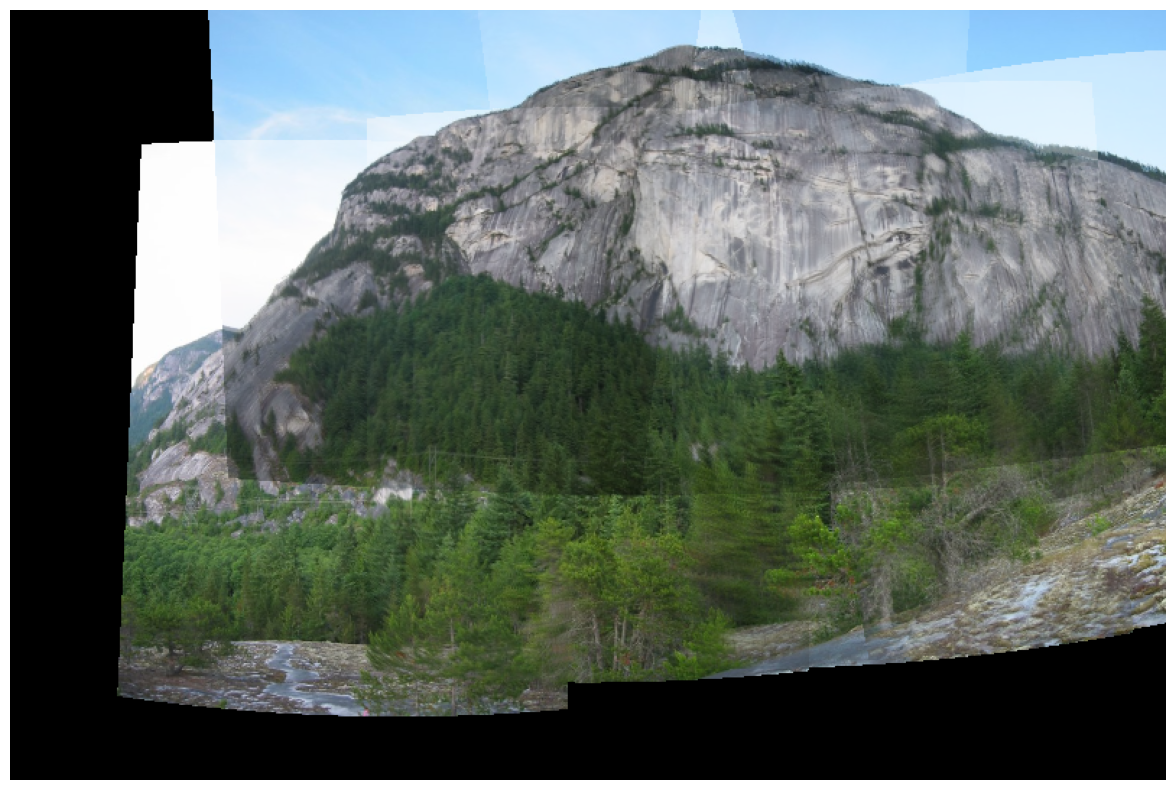

In [30]:
pano.align_panorama()

render_params={}
render_params['render_width']=800
render_params['theta_min']=-45
render_params['theta_max']=45
render_params['phi_min']=-30
render_params['phi_max']=30

pano_im = pano.render(render_params)

plt.plot()
plt.imshow(pano_im)
plt.axis('off')

### 测试和改进全景拼接器 [20%]

您现在应该已经完成了一个基本的全景图拼接器的实现。尝试使用几组不同的图像集进行测试，并记录结果中的任何问题/伪影。如何改进结果？列出可能的改进措施，并考虑您可能想要添加的新功能。现在实现其中一些改进/新功能，并在下面的笔记本中记录您的工作。

我采用以下三个案例进行测试：
1. 花朵的微距拍摄(4)。在这个案例中，由于多张图片出现在同一个像素位置上，这些像素呈现出稍微模糊的效果，这表明图像对齐不够准确
2. 广角的建筑拍摄(6)。这个案例采用比较宽的视场角，可以注意到地表上的花纹并没有很好地对齐
3. 俯视图拍摄(3)，纵向拼接。我观察到地物的对齐效果很差，出现了大量的虚影

当图片中存在大量重复的特征时，匹配算法在处理这些特征产生的兴趣点上可能会出现匹配错误，导致无法正确计算旋转矩阵。我们可以考虑在匹配算法中增大 patch 的大小，或者考虑在匹配时考虑一些全局的相对位置信息；另外我们也可以考虑提高兴趣点计算的方法，使得不同图片上同一事物上的兴趣点更加一致。

我尝试通过减小 DescriptorExtractor 中的 ratio 参数，并且在 match.py 中改用 match_ratio_test 函数来计算匹配的兴趣点，使得其对 patch 的匹配判定更加严格。在前两个案例中没有看到显著的改进；第三个案例的地物重影之间距离明显减小了，但是仍然存在。此外，由于参与 RANSAC 算法的兴趣点减少，计算速度有显著提升。

In [31]:
# test workflow for arbitrary image set
def test_workflow(image_dir, stitch_params, render_params):
    im_filenames=os.listdir(image_dir)
    im_filenames=sorted(im_filenames)
    im_filenames=[image_dir+'/'+fname for fname in im_filenames]
    images=[]
    for fname in im_filenames:
        images.append(im_util.image_open(fname))
    pano=panorama.PanoramaStitcher(images, stitch_params)
    pano.match_images()
    print(' num_matches=')
    print(pano.num_matches)
    pano.align_panorama()
    pano_im = pano.render(render_params)
    plt.plot()
    plt.imshow(pano_im)
    plt.axis('off')

[ find interest points ]
 found 466 interest points
 found 426 interest points
 found 396 interest points
 found 366 interest points
  47.34 secs 
[ match descriptors ]
 image 0
 image 1
 image 2
 image 3
 -42.12 secs
 num_matches=
[[  0. 156.  30.   5.]
 [151.   0. 121.  32.]
 [ 25. 127.   0. 104.]
 [  4.  29. 102.   0.]]
(0, 1)
(1, 2)
(2, 3)
[ render panorama ]
  0.30 secs


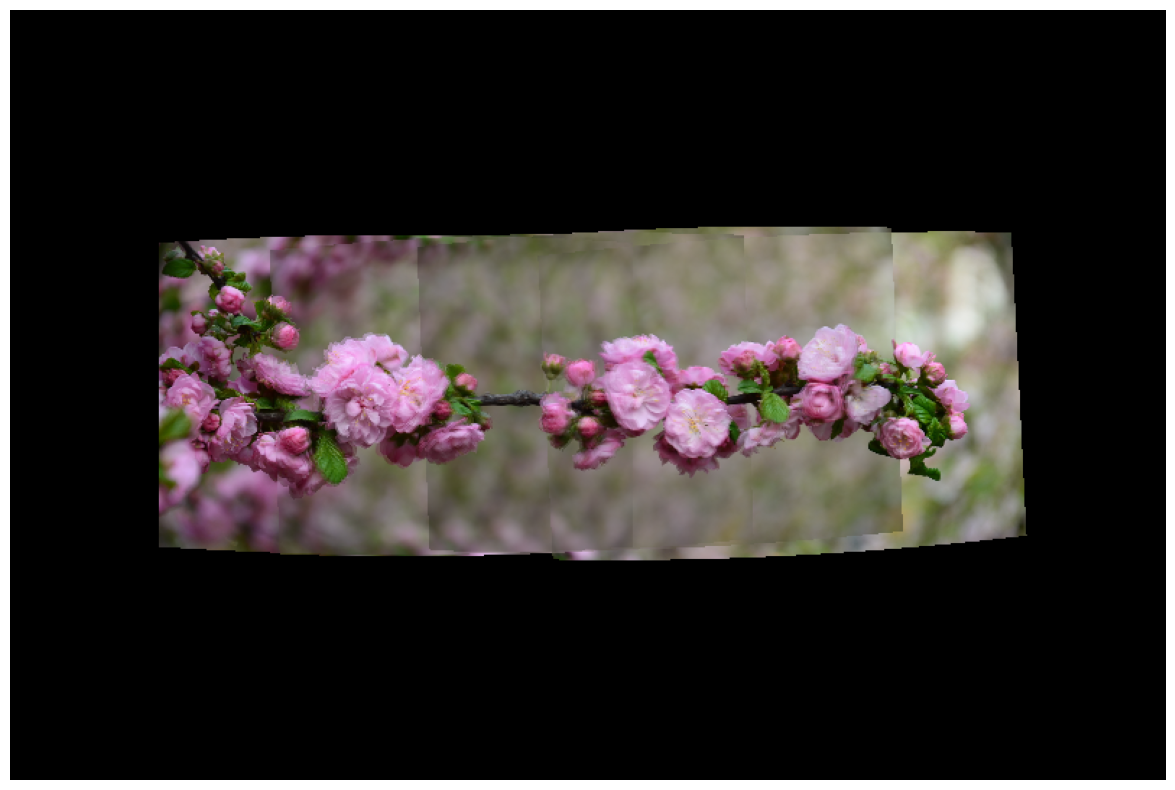

In [32]:
render_params['phi_min']=-30
render_params['phi_max']=30
render_params['theta_min']=-30
render_params['theta_max']=60
test_workflow("./data/flower", {"fov_degrees": 37}, render_params)

[ find interest points ]
 found 339 interest points
 found 470 interest points
 found 630 interest points
 found 546 interest points
 found 486 interest points
 found 510 interest points
  2.87 secs 
[ match descriptors ]
 image 0
 image 1
 image 2
 image 3
 image 4
 image 5
  5.15 secs
 num_matches=
[[  0.  53.  18.   5.   7.   7.]
 [ 56.   0.  75.  21.  10.   9.]
 [ 16.  73.   0.  97.   7.   8.]
 [  4.  18. 106.   0.  31.   9.]
 [  4.   5.   9.  33.   0.  47.]
 [  4.   7.   5.  11.  53.   0.]]
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 5)
[ render panorama ]
  0.29 secs


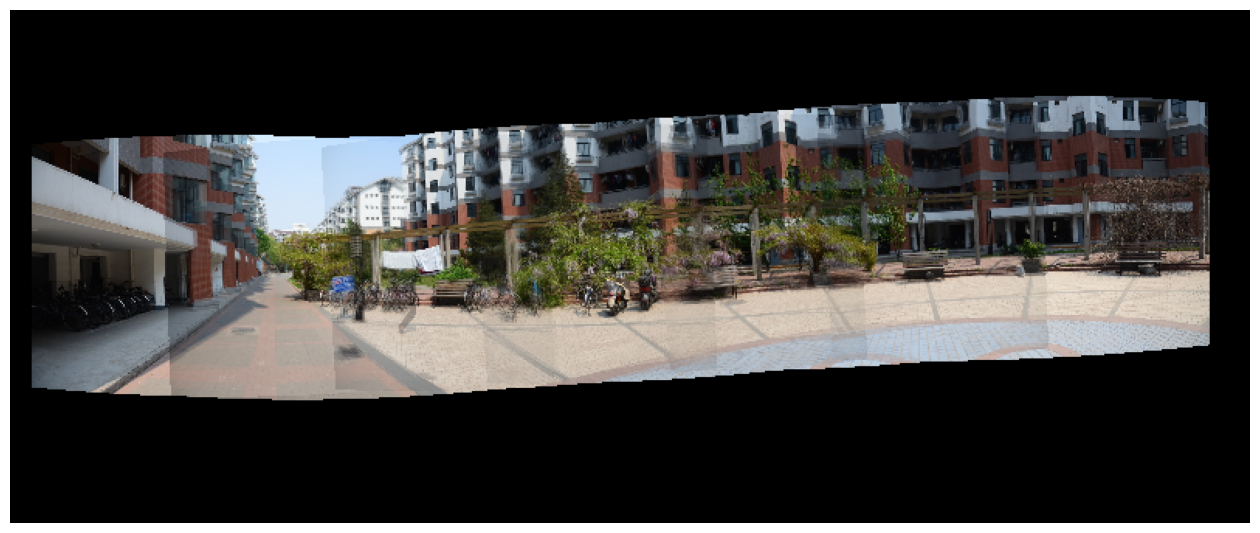

In [33]:
render_params['render_width']=800
render_params['theta_min']=-25
render_params['theta_max']=120
test_workflow("./data/zijing", {"fov_degrees": 45}, render_params)

[ find interest points ]
 found 570 interest points
 found 855 interest points
 found 860 interest points
  7.34 secs 
[ match descriptors ]
 image 0
 image 1
 image 2
  2.15 secs
 num_matches=
[[ 0. 61. 25.]
 [69.  0. 52.]
 [21. 49.  0.]]
(0, 1)
(1, 2)
[ render panorama ]
  0.45 secs


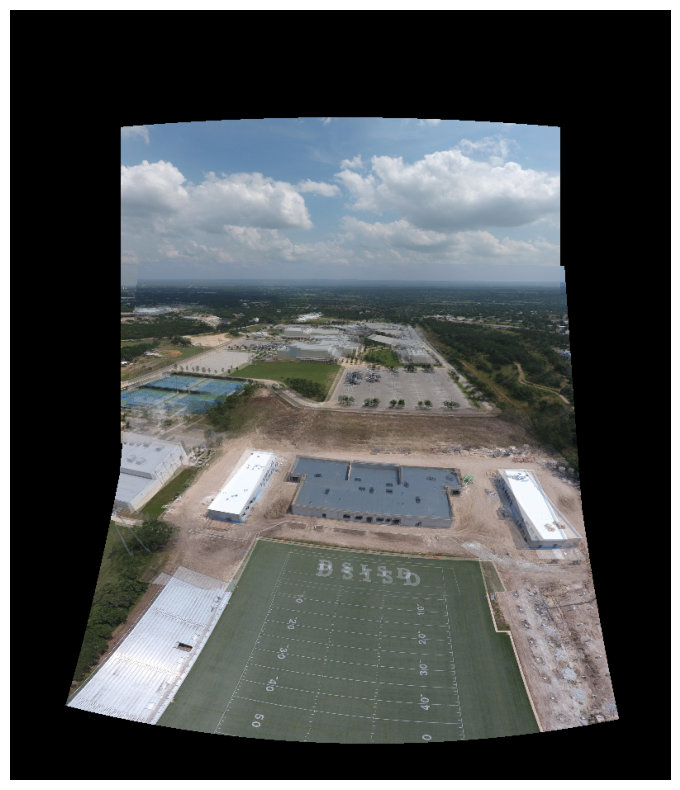

In [34]:
render_params['phi_min']=-45
render_params['phi_max']=25
render_params['theta_min']=-30
render_params['theta_max']=30
test_workflow("./data/birdview", {"fov_degrees": 40}, render_params)